In [1]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import skimage.measure
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 18
mpl.rcParams['font.size'] = 18

np.random.seed(1942)

# 1. Confidence Intervals of $\beta$s
Here, we derive and plot the confidence intervals of the parameters $\beta$. We will be using OLS with KFolding, and polynomial order 5.

## 1.1 Franke Data

In [2]:
x, y = np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

In [3]:
X = reg.get_X(reg.x_flat, reg.y_flat, 5)

df = X.shape[0]*X.shape[1] - 1

XTX_diag = np.diagonal(np.linalg.pinv(X.T@X))

data_pred = reg.solveKFold(store_beta=True)
beta = reg.beta
sigma_estimate2 = 1/(X.shape[0] - X.shape[1] - 1)*np.sum((data_pred - reg.f)**2)  # Estimator of sigma squared (variance) of data.
sigma_beta = np.sqrt(XTX_diag*sigma_estimate2)  # Estimator of variance of beta.
S_beta = np.linalg.pinv(X.T@X)

t_05 = scipy.stats.t.cdf(0.05, df)
beta_cf = np.zeros((len(XTX_diag), 2))
beta_err = t_05*sigma_beta
beta_cf[:,0] = beta - t_05*sigma_beta
beta_cf[:,1] = beta + t_05*sigma_beta

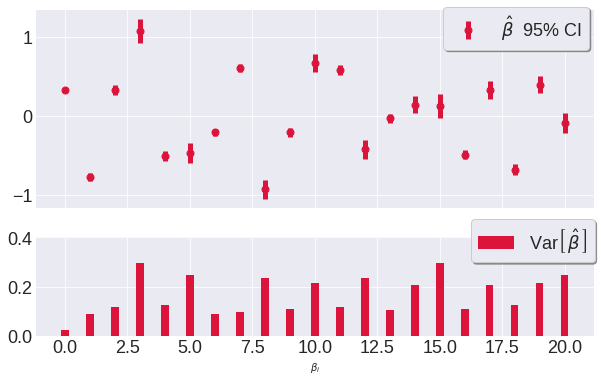

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
asdf = np.arange(0, len(beta))
ax1.errorbar(asdf, beta, yerr=beta_err, fmt="o", ms=7, elinewidth=5, color="crimson", label=r"$\hat{\beta}$  95% CI");
plt.xlabel(r"$\beta_i$")
ax2.bar(asdf, sigma_beta, width=0.3, color="crimson", label=r"Var$\left[\, \hat{\beta}\, \right]$");
ax2.set_ylim(0, 0.4);
ax1.legend(shadow=True, frameon=True, fontsize=18, loc=(0.73, 0.8));
ax2.legend(shadow=True, frameon=True, fontsize=18, loc=(0.78, 0.75));
plt.savefig("../figs/CI_Franke.pdf", bbox_inches="tight")

## 1.2 Terrain Data (32x32 downsampled)

In [5]:
terrain0 = imread("../input_data/SRTM_data_Norway_1.tif")/1000
terrain32 = skimage.measure.block_reduce(terrain0, (32, 32), np.mean)
reg.load_matrix_data(terrain32)

In [8]:
X = reg.get_X(reg.x_flat, reg.y_flat, 5)

df = X.shape[0]*X.shape[1] - 1

XTX_diag = np.diagonal(np.linalg.pinv(X.T@X))

data_pred = reg.solveKFold(store_beta=True)
beta = reg.beta
sigma_estimate2 = 1/(X.shape[0] - X.shape[1] - 1)*np.sum((data_pred - reg.f)**2)
sigma_beta = np.sqrt(XTX_diag*sigma_estimate2)
S_beta = np.linalg.pinv(X.T@X)

t_05 = scipy.stats.t.cdf(0.05, df)
beta_cf = np.zeros((len(XTX_diag), 2))
beta_err = t_05*sigma_beta
beta_cf[:,0] = beta - t_05*sigma_beta
beta_cf[:,1] = beta + t_05*sigma_beta

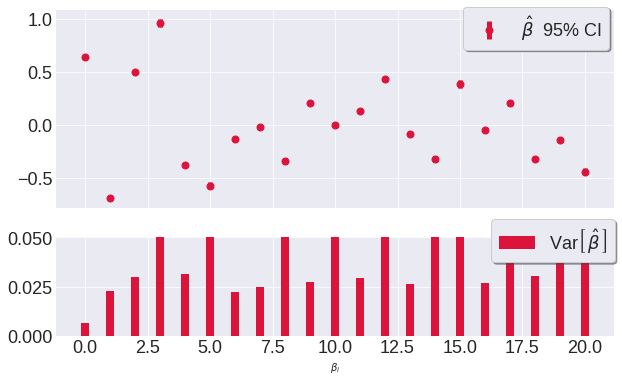

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
asdf = np.arange(0, len(beta))
ax1.errorbar(asdf, beta, yerr=beta_err, fmt="o", ms=7, elinewidth=5, color="crimson", label=r"$\hat{\beta}$  95% CI");
plt.xlabel(r"$\beta_i$")
ax2.bar(asdf, sigma_beta, width=0.3, color="crimson", label=r"Var$\left[\, \hat{\beta}\, \right]$");
ax2.set_ylim(0, 0.05);
ax1.legend(shadow=True, frameon=True, fontsize=18, loc=(0.73, 0.8));
ax2.legend(shadow=True, frameon=True, fontsize=18, loc=(0.78, 0.75));
plt.savefig("../figs/CI_Terrain.pdf", bbox_inches="tight")